In [12]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
import seaborn as sns
from scipy.stats import pearsonr
import optuna

import warnings
warnings.filterwarnings("ignore")


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

In [2]:
def gen_lagged_data(metadata, data, last_date, lag):
    lagged_data = data.loc[data.date <= last_date, :].reset_index(drop=True)
    for col in lagged_data.columns[1:]:
        pub_lag = metadata.loc[metadata.series == col, "months_lag"].values[0] 
        lagged_data.loc[(len(lagged_data) - pub_lag + lag - 1) :, col] = np.nan

    return lagged_data

def flatten_data(data, target_variable, n_lags):
    flattened_data = data.loc[~pd.isna(data[target_variable]), :]
    orig_index = flattened_data.index
    for i in range(1, n_lags + 1):
        lagged_indices = orig_index - i
        lagged_indices = lagged_indices[lagged_indices >= 0]
        tmp = data.loc[lagged_indices, :]
        tmp.date = tmp.date + pd.DateOffset(months=i)
        tmp = tmp.drop([target_variable], axis=1)
        tmp.columns = [j + "_" + str(i) if j != "date" else j for j in tmp.columns]
        flattened_data = flattened_data.merge(tmp, how="left", on="date")

    return flattened_data

def mean_fill_dataset(training, test):
    mean_dict = {}
    for col in training.columns[1:]:
        mean_dict[col] = np.nanmean(training[col])
    filled = test.copy()
    for col in training.columns[1:]:
        filled.loc[pd.isna(filled[col]), col] = mean_dict[col]
    return filled

# Data set up

In [3]:
data = pd.read_excel("C:/Users/lysov/Desktop/4 курс/ВКР/New Data/data_tf.xlsx", decimal = ',', parse_dates=["date"])
metadata = pd.read_csv("C:/Users/lysov/Desktop/4 курс/ВКР/New Data/meta_data.csv", delimiter = ";")
data_num = data.loc[:, data.columns != 'date']

target_variable = "gdp"

lags = list(range(-2, 3))

train_start_date = "2011-01-01"
train_end_date = "2018-12-01"
test_start_date = "2019-03-01"
test_end_date = "2023-09-01"

test = data.loc[(data.date >= train_start_date) & (data.date <= test_end_date), :].reset_index(drop=True)

Data should be a dataframe of seasonally adjusted growth rates with months in rows and quarterly variables in the last month of the quarter, with `np.nan`s for interquarter months.

In [ ]:
# names = ['date', 'gdp',
#          # sectors
#          'agri', 'mining', 'manufacturing', 'egpiv', 'construction', 'trade', 'transport', 'finance', 'real_estate', 'others', 'taxes',
#          # PMI
#          'PMI_Mnf', 'PMI_Serv', 'PMI_Comp',
#          # IBC total
#          'IBC_total',  'IBC_total_fact', 'IBC_total_3m', 'IBC_total_output', 'IBC_total_output_3m', 'IBC_total_demand',
#          'IBC_total_demand_3m', 'IBC_total_price', 'IBC_total_price_3m','IBC_total_costs', 'IBC_total_credit',
#          # IBC ip
#          'IBC_ip', 'IBC_ip_fact', 'IBC_ip_3m', 'IBC_ip_output', 'IBC_ip_output_3m', 'IBC_ip_demand',
#          'IBC_ip_demand_3m', 'IBC_ip_price', 'IBC_ip_price_3m', 'IBC_ip_costs', 'IBC_ip_credit', 
#          # IBC mining
#          'IBC_mining', 'IBC_mining_fact', 'IBC_mining_3m', 'IBC_mining_output', 'IBC_mining_output_3m', 'IBC_mining_demand',
#          'IBC_mining_demand_3m', 'IBC_mining_price', 'IBC_mining_price_3m', 'IBC_mining_costs', 'IBC_mining_credit',
#          # IBC manufacturing
#          'IBC_mnf', 'IBC_mnf_fact', 'IBC_mnf_3m', 'IBC_mnf_output', 'IBC_mnf_output_3m', 'IBC_mnf_demand',
#          'IBC_mnf_demand_3m', 'IBC_mnf_price', 'IBC_mnf_price_3m', 'IBC_mnf_costs', 'IBC_mnf_credit',
#          # IBC constr
#          'IBC_constr', 'IBC_constr_fact', 'IBC_constr_3m', 'IBC_constr_output','IBC_constr_output_3m', 'IBC_constr_demand',
#          'IBC_constr_demand_3m', 'IBC_constr_price', 'IBC_constr_price_3m', 'IBC_constr_costs', 'IBC_constr_credit',
#          # IBC trade
#          'IBC_trade', 'IBC_trade_fact', 'IBC_trade_3m', 'IBC_trade_output', 'IBC_trade_output_3m', 'IBC_trade_demand',
#          'IBC_trade_demand_3m', 'IBC_trade_price', 'IBC_trade_price_3m', 'IBC_trade_costs', 'IBC_trade_credit',
#          # IBC transp
#          'IBC_transp', 'IBC_transp_fact', 'IBC_transp_3m', 'IBC_transp_output', 'IBC_transp_output_3m', 'IBC_transp_demand', 
#          'IBC_transp_demand_3m', 'IBC_transp_price', 'IBC_transp_price_3m', 'IBC_transp_costs', 'IBC_transp_credit',
#          # IBC serv
#          'IBC_serv', 'IBC_serv_fact', 'IBC_serv_3m', 'IBC_serv_output', 'IBC_serv_output_3m', 'IBC_serv_demand',
#          'IBC_serv_demand_3m', 'IBC_serv_price', 'IBC_serv_price_3m', 'IBC_serv_costs', 'IBC_serv_credit',
#          # hse + rspp
#          'hse', 'rspp1', 'rspp2', 'rspp3', 'rspp4', 'rspp5', 'rspp6', 'rspp7',
#          # ipu rosstat
#          'ipu_constr1', 'ipu_constr2', 'ipu_constr3',
#         #  # ip
#          'ip', 'ip_raw',  'ip_coal', 'ip_oil_products',
#          'ip_chemicals', 'ip_man', 'ip_metals', 'ip_constr', 'ip_cars', 'ip_food', 'ip_nonfood', 'ip_el',
#          # rail + cargo
#          'rail', 'cargo_rail', 'cargo_auto', 'cargo_sea', 'cargo_pipe',
#          # constr
#          'constr_vol', 'constr_prices',
#          # serv
#          'retail_prod', 'retail_neprod', 'pserv', 'obschepit',
#          # labor
#          'dispinc', 'eap', 'unemp', 'nwage',
#          # cars
#          'cars', 'trucks',
#          # financial
#          'miacr', 'rtc', 'moex', 'reer', 'rvi', 'm0', 'm2x', 'ofz1', 'ofz3', 'ofz5', 'ofz10',
#          # dep/cred rates 
#          'dep_hh_rate', 'dep_nfo_rate', 'cred_hh_rate', 'cred_nfo_rate',
#          # ust
#          't2', 't10',
#          # external conditions
#          'ism_man', 'ism_serv', 'us_cpi', 'eu_cpi', 'cpi', 'cpi_prod', 'cpi_neprod', 'cpi_serv', 'ppi',
#          'brent', 'urals', 'aluminium', 'gold', 'gas']

# data = data.loc[:, names]
# # test dataset
# test = data.loc[(data.date >= train_start_date) & (data.date <= test_end_date), :].reset_index(drop=True)

In [4]:
corr = data_num.corr(method='pearson')

columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = data_num.columns[columns].insert(0, 'date')

data_selected = data.loc[:, selected_columns]
test_selected = data_selected.loc[(data_selected.date >= train_start_date) & (data_selected.date <= test_end_date), :].reset_index(drop=True)

In [5]:
def r_pvalues(df):
    cols = pd.DataFrame(columns=df.columns)
    p = cols.transpose().join(cols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            p[r][c] = round(pearsonr(tmp[r], tmp[c])[1], 4)
    return p


In [6]:
data_num = data.loc[:, data.columns != 'date']
pvals = r_pvalues(data_num)

In [13]:
def nowcast_lasso(model_params, target_variable, dates, actuals):
    
    selected_columns = data_num.loc[:, pvals[target_variable] < model_params['pval']].columns
    selected_columns = selected_columns.insert(0, 'date')
    data_selected = data.loc[:, selected_columns]
    test_selected = data_selected.loc[(data_selected.date >= train_start_date) & (data_selected.date <= test_end_date), :].reset_index(drop=True)
    test_t = test_selected

    pred_dict = {k: [] for k in lags}
    try:
        for date in dates:
            train = test_t.loc[test_t.date <= str(pd.to_datetime(date) - pd.tseries.offsets.DateOffset(months=3))[:10],:] 
            transformed_train = mean_fill_dataset(train, train)
            transformed_train = flatten_data(transformed_train, target_variable, model_params['flat']) 
            transformed_train = transformed_train.loc[transformed_train.date.dt.month.isin([3,6,9,12]),:].dropna(axis=0, how="any").reset_index(drop=True)
            
            
            model = Lasso(alpha = model_params['alpha'])
            x = transformed_train.drop(["date", target_variable], axis=1)
            y = transformed_train[target_variable]
            model.fit(x, y)
            
            for lag in lags:
                tmp_data = gen_lagged_data(metadata, test_t, date, lag)

                tmp_data = mean_fill_dataset(train, tmp_data)
                tmp_data = flatten_data(tmp_data, target_variable, model_params['flat'])
                x = tmp_data.loc[tmp_data.date == date, :].drop(["date", target_variable], axis=1)
                
                pred = model.predict(x)[0]
                pred_dict[lag].append(pred)
                  
        curr_MAE = np.mean(np.abs((np.array(actuals) - np.array(pred_dict[2]))))
    except: curr_MAE = 1000

    return curr_MAE

In [14]:
def objective(trial):
    dates = (
        pd.date_range(test_start_date, test_end_date, freq="3MS")
        .strftime("%Y-%m-%d")
        .tolist()
    )
    
    actuals = list(test.loc[test.date.isin(dates), target_variable].values)

    pval = trial.suggest_loguniform('pval', 1e-5, 1)
    alpha = trial.suggest_loguniform('alpha', 1e-3, 1e5)
    flat = trial.suggest_int('flat', 2, 7, step=1)

    model_params = {'pval': pval, 'alpha': alpha, "flat": flat}
    
    return nowcast_lasso(model_params, target_variable=target_variable, dates=dates, actuals=actuals)
    


In [17]:
def evaluate_lasso(data, model_params, target_variable, plot, save):
    target_variable = target_variable
    alpha = model_params['alpha']
    pval = model_params['pval']
    flat = model_params['flat']
    
    dates = (
        pd.date_range(test_start_date, test_end_date, freq="3MS")
        .strftime("%Y-%m-%d")
        .tolist()
    )

    actuals = list(test.loc[test.date.isin(dates), target_variable].values)

    selected_columns = data_num.loc[:, pvals[target_variable] < pval].columns
    selected_columns = selected_columns.insert(0, 'date')
    data_selected = data.loc[:, selected_columns]
    test_selected = data_selected.loc[(data_selected.date >= train_start_date) & (data_selected.date <= test_end_date), :].reset_index(drop=True)
    test_t = test_selected
    
    pred_dict = {k: [] for k in lags}
    for date in dates:
        train = test_t.loc[test_t.date <= str(pd.to_datetime(date) - pd.tseries.offsets.DateOffset(months=3))[:10],:]
        transformed_train = mean_fill_dataset(train, train) 
        transformed_train = flatten_data(transformed_train, target_variable, flat)
        transformed_train = transformed_train.loc[transformed_train.date.dt.month.isin([3,6,9,12]),:].dropna(axis=0, how="any").reset_index(drop=True)
        
        model = Lasso(alpha = alpha)
        x = transformed_train.drop(["date", target_variable], axis=1)
        y = transformed_train[target_variable]
        model.fit(x, y)
        
        for lag in lags:
            tmp_data = gen_lagged_data(metadata, test_t, date, lag)

            tmp_data = mean_fill_dataset(train, tmp_data)
            tmp_data = flatten_data(tmp_data, target_variable, flat)
            x = tmp_data.loc[tmp_data.date == date, :].drop(["date", target_variable], axis=1)
            
            pred = model.predict(x)[0]
            pred_dict[lag].append(pred)
    
    performance = pd.DataFrame(columns=["Vintage", "RMSE", "MAE"])
    for lag in lags:
        tmp = pd.DataFrame({
            "Vintage":lag,
            "RMSE":np.sqrt(np.mean((np.array(actuals) - np.array(pred_dict[lag])) ** 2)),
            "MAE":np.mean(np.abs((np.array(actuals) - np.array(pred_dict[lag]))))
        }, index=[0])
        performance = pd.concat([performance, tmp]).reset_index(drop=True)
    
    print(performance.round(4))

    if plot == 1:
        predictions_elastic = pd.DataFrame({
            "actuals":actuals, 
            "two_back":pred_dict[-2], 
            "one_back":pred_dict[-1], 
            "zero_back":pred_dict[0],
            "one_ahead":pred_dict[1],
            "two_ahead":pred_dict[2]}
        )
        predictions_elastic.plot()

    if save == 1:
        predictions_elastic.to_excel(f"predictions_{target_variable}_lasso.xlsx")
        

In [16]:
target_variable = 'gdp'
study = optuna.create_study()
study.optimize(objective, n_trials = 300)
gdp_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-05-03 15:14:53,538] A new study created in memory with name: no-name-cdc935b2-6356-4a83-b284-85e842fb50ec
[I 2024-05-03 15:14:57,510] Trial 0 finished with value: 1.6590979952623326 and parameters: {'pval': 3.748856335806094e-05, 'alpha': 0.051076992312969846, 'flat': 2}. Best is trial 0 with value: 1.6590979952623326.
[I 2024-05-03 15:15:20,026] Trial 1 finished with value: 1.5436732544453962 and parameters: {'pval': 0.5141792330589267, 'alpha': 0.10144969133339862, 'flat': 4}. Best is trial 1 with value: 1.5436732544453962.
[I 2024-05-03 15:15:28,564] Trial 2 finished with value: 2.319342743038412 and parameters: {'pval': 2.231270329477239e-05, 'alpha': 0.001748190028678627, 'flat': 7}. Best is trial 1 with value: 1.5436732544453962.
[I 2024-05-03 15:15:35,840] Trial 3 finished with value: 1.7201847402831858 and parameters: {'pval': 0.006244560693579176, 'alpha': 126.27260541910105, 'flat': 4}. Best is trial 1 with value: 1.5436732544453962.
[I 2024-05-03 15:15:39,611] Trial 

Best MAE=1.1338893734679305, best parameters:{'pval': 0.030536993574851404, 'alpha': 0.1165070897995601, 'flat': 2}


  Vintage    RMSE     MAE
0      -2  2.8317  1.7028
1      -1  2.8317  1.7028
2       0  2.7923  1.6830
3       1  1.9935  1.2884
4       2  1.7661  1.1339


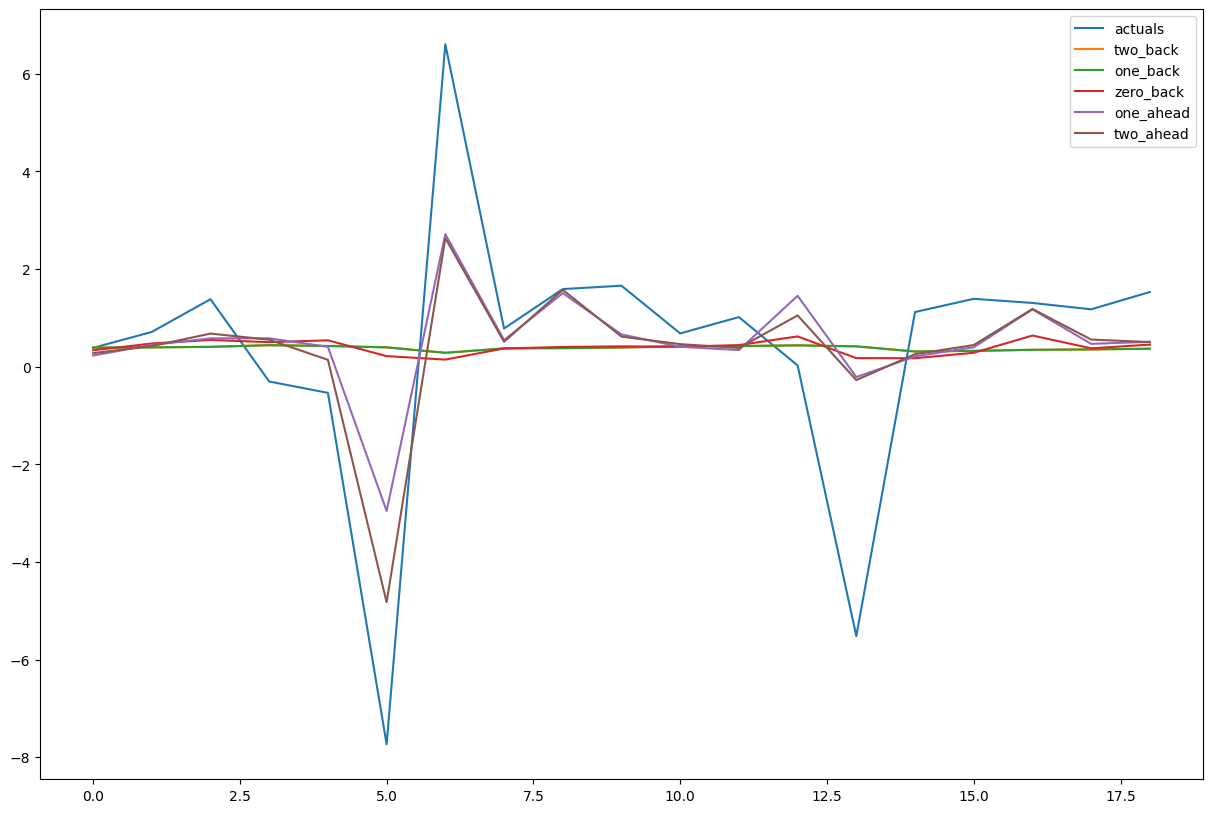

In [19]:
evaluate_lasso(data = data, target_variable='gdp', model_params=gdp_opt, plot=1, save=1)

In [20]:
target_variable = 'agri'
study = optuna.create_study()
study.optimize(objective, n_trials = 300)
agri_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-05-03 16:17:47,250] A new study created in memory with name: no-name-54ceb7d6-a096-4edf-be63-c8873721344f
[I 2024-05-03 16:17:47,333] Trial 0 finished with value: 1000.0 and parameters: {'pval': 0.00021821791014519176, 'alpha': 0.01410504520729142, 'flat': 6}. Best is trial 0 with value: 1000.0.
[I 2024-05-03 16:17:47,378] Trial 1 finished with value: 1000.0 and parameters: {'pval': 0.0013168141829560166, 'alpha': 13.29393104532357, 'flat': 3}. Best is trial 0 with value: 1000.0.
[I 2024-05-03 16:17:47,436] Trial 2 finished with value: 1000.0 and parameters: {'pval': 0.00022991658124386062, 'alpha': 52.96575773210887, 'flat': 5}. Best is trial 0 with value: 1000.0.
[I 2024-05-03 16:17:47,489] Trial 3 finished with value: 1000.0 and parameters: {'pval': 0.0010305498237097091, 'alpha': 40.765513858585926, 'flat': 4}. Best is trial 0 with value: 1000.0.
[I 2024-05-03 16:17:52,076] Trial 4 finished with value: 0.31977103671183665 and parameters: {'pval': 0.013204113437449141, 'alph

Best MAE=0.283944766688163, best parameters:{'pval': 0.017318688038329314, 'alpha': 0.21765899807110972, 'flat': 2}


  Vintage    RMSE     MAE
0      -2  0.4312  0.3194
1      -1  0.4312  0.3194
2       0  0.4312  0.3194
3       1  0.4344  0.3247
4       2  0.4140  0.2839


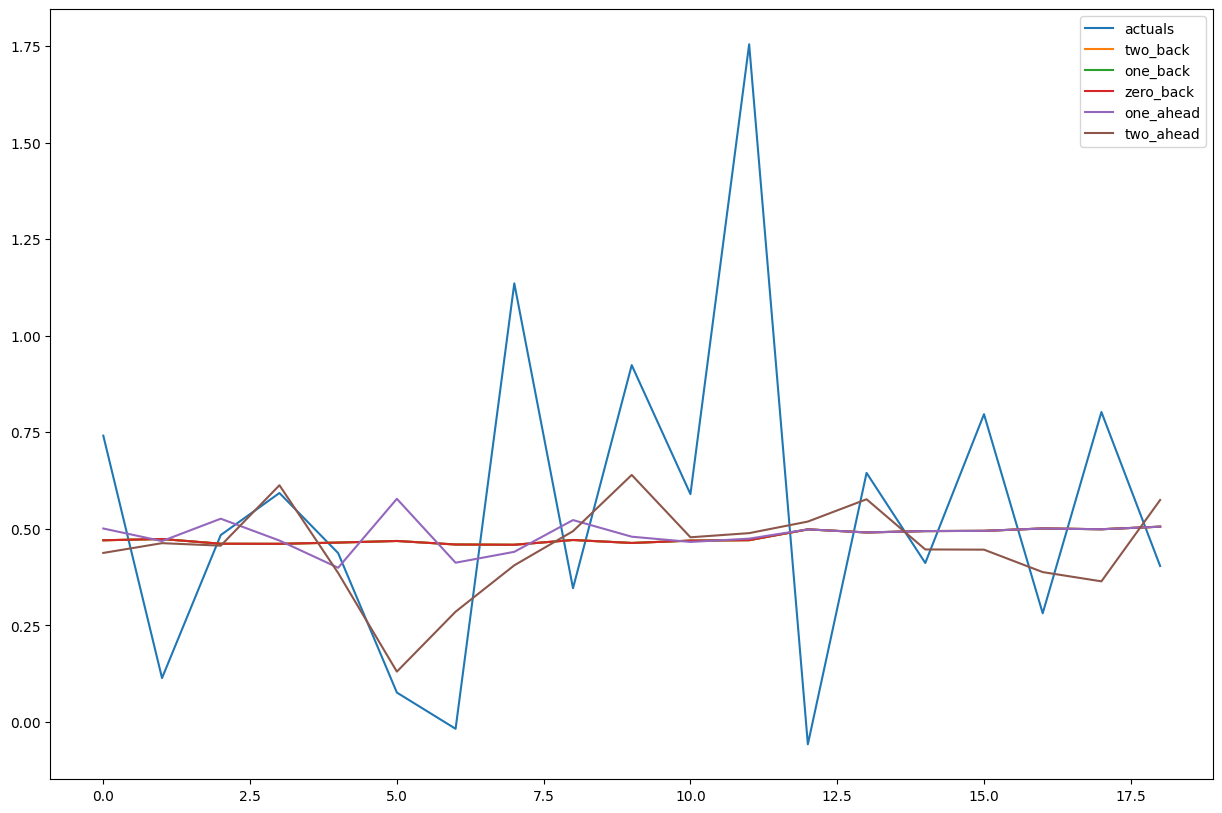

In [21]:
evaluate_lasso(data = data, target_variable='agri', model_params=agri_opt, plot=1, save=1)

In [22]:
target_variable = 'mining'
study = optuna.create_study()
study.optimize(objective, n_trials = 300)
mining_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-05-03 16:55:14,353] A new study created in memory with name: no-name-8a6d0ea2-b335-449c-ab75-261c9eeb7ad3
[I 2024-05-03 16:55:19,478] Trial 0 finished with value: 3.0003240443746124 and parameters: {'pval': 0.00048136412254594504, 'alpha': 0.09713195323466726, 'flat': 7}. Best is trial 0 with value: 3.0003240443746124.
[I 2024-05-03 16:55:27,271] Trial 1 finished with value: 2.1175475306495035 and parameters: {'pval': 0.03780513916528691, 'alpha': 315.8835504763296, 'flat': 6}. Best is trial 1 with value: 2.1175475306495035.
[I 2024-05-03 16:55:43,496] Trial 2 finished with value: 2.1175475306495035 and parameters: {'pval': 0.6926764493665076, 'alpha': 43.709106028905026, 'flat': 6}. Best is trial 1 with value: 2.1175475306495035.
[I 2024-05-03 16:55:52,033] Trial 3 finished with value: 4.296808828684544 and parameters: {'pval': 0.08346658666746706, 'alpha': 0.003199693447744356, 'flat': 5}. Best is trial 1 with value: 2.1175475306495035.
[I 2024-05-03 16:55:55,960] Trial 4 fin

Best MAE=2.1170942670562316, best parameters:{'pval': 0.006483560269322244, 'alpha': 24.0263740642271, 'flat': 6}


  Vintage    RMSE     MAE
0      -2  3.2662  2.1174
1      -1  3.2662  2.1174
2       0  3.2661  2.1171
3       1  3.2661  2.1171
4       2  3.2661  2.1171


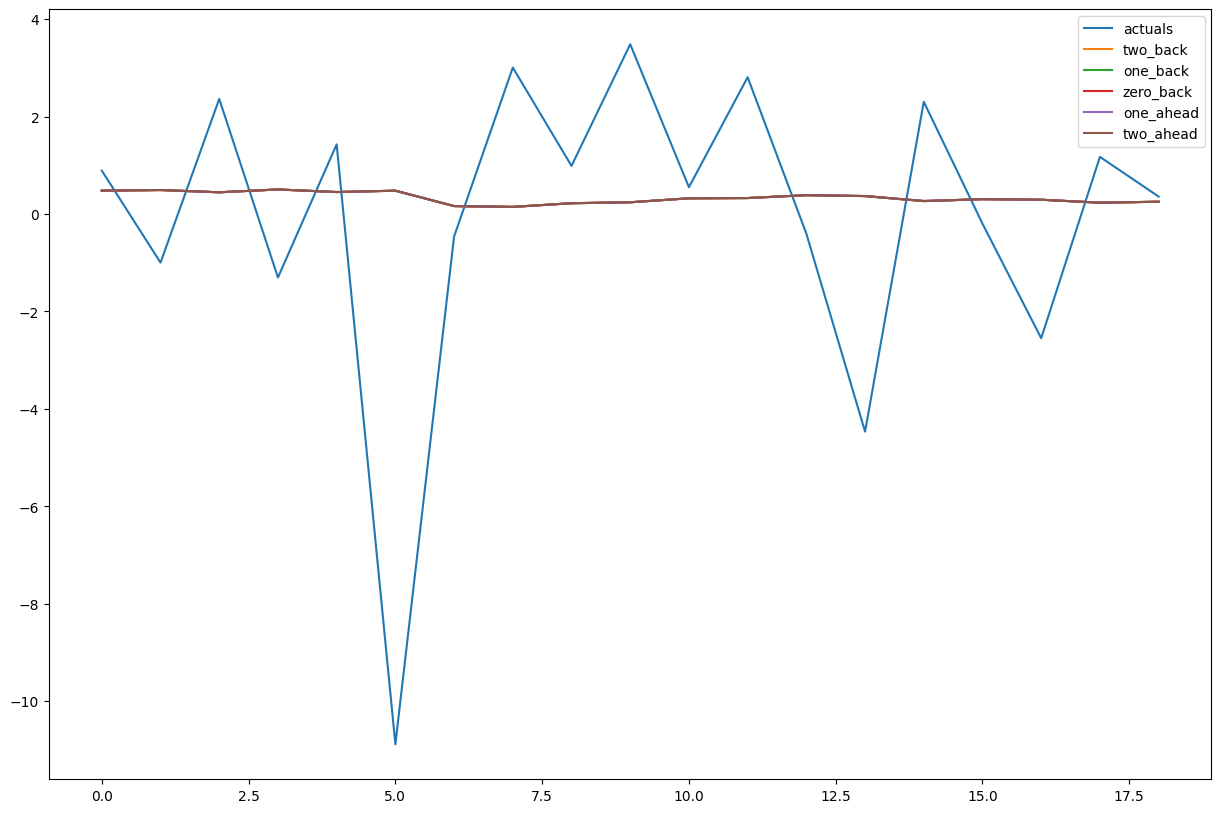

In [23]:
evaluate_lasso(data = data, target_variable='mining', model_params=mining_opt, plot=1, save=1)

In [24]:
target_variable = 'manufacturing'
study = optuna.create_study()
study.optimize(objective, n_trials = 300)
manufacturing_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-05-03 17:47:58,459] A new study created in memory with name: no-name-27a50637-8bf1-473f-9bc9-053cbfdad703
[I 2024-05-03 17:48:07,152] Trial 0 finished with value: 2.5037308615827523 and parameters: {'pval': 0.1661938867874891, 'alpha': 0.04641960331556086, 'flat': 4}. Best is trial 0 with value: 2.5037308615827523.
[I 2024-05-03 17:48:12,895] Trial 1 finished with value: 2.3550633408113586 and parameters: {'pval': 0.0001741364862771233, 'alpha': 1254.6746361146654, 'flat': 6}. Best is trial 1 with value: 2.3550633408113586.
[I 2024-05-03 17:48:17,754] Trial 2 finished with value: 2.11262055868465 and parameters: {'pval': 0.053496250030206055, 'alpha': 0.12024403099067792, 'flat': 3}. Best is trial 2 with value: 2.11262055868465.
[I 2024-05-03 17:48:27,270] Trial 3 finished with value: 2.3280657471317983 and parameters: {'pval': 0.26153317382573693, 'alpha': 0.0031098756388646875, 'flat': 5}. Best is trial 2 with value: 2.11262055868465.
[I 2024-05-03 17:48:31,805] Trial 4 finis

Best MAE=2.0432736578152007, best parameters:{'pval': 6.75046574790889e-05, 'alpha': 0.018393987937149896, 'flat': 7}


  Vintage    RMSE     MAE
0      -2  3.1660  2.3184
1      -1  3.1045  2.0987
2       0  3.1045  2.0987
3       1  3.1045  2.0987
4       2  2.8691  2.0433


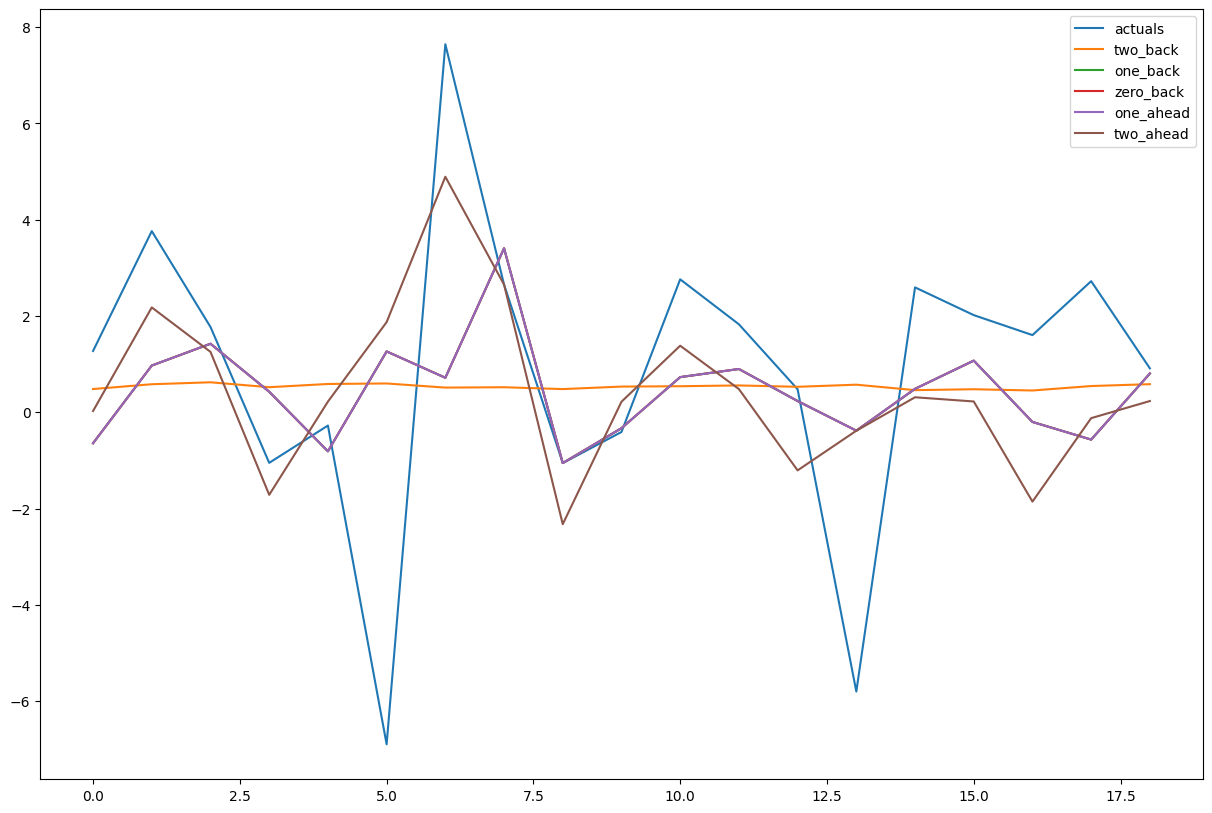

In [25]:
evaluate_lasso(data = data, target_variable='manufacturing', model_params=manufacturing_opt, plot=1, save=1)

In [26]:
target_variable = 'construction'
study = optuna.create_study()
study.optimize(objective, n_trials = 300)
construction_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-05-03 18:25:36,633] A new study created in memory with name: no-name-1d784dc8-be6e-466d-bcc1-75ef61a7c5b9
[I 2024-05-03 18:25:41,508] Trial 0 finished with value: 3.367191078885275 and parameters: {'pval': 6.0672136286590165e-05, 'alpha': 467.90094519454175, 'flat': 6}. Best is trial 0 with value: 3.367191078885275.
[I 2024-05-03 18:25:43,752] Trial 1 finished with value: 3.3640709629826353 and parameters: {'pval': 1.063347006116444e-05, 'alpha': 2.3779588256065654, 'flat': 2}. Best is trial 1 with value: 3.3640709629826353.
[I 2024-05-03 18:25:46,590] Trial 2 finished with value: 3.3640709629826353 and parameters: {'pval': 7.240686957763215e-05, 'alpha': 62.82354930928674, 'flat': 3}. Best is trial 1 with value: 3.3640709629826353.
[I 2024-05-03 18:25:52,639] Trial 3 finished with value: 3.3640709629826353 and parameters: {'pval': 0.15517013717632674, 'alpha': 109.67671003220498, 'flat': 4}. Best is trial 1 with value: 3.3640709629826353.
[I 2024-05-03 18:25:57,203] Trial 4 fi

Best MAE=2.725771143714354, best parameters:{'pval': 0.023344265615100192, 'alpha': 0.9086625775969168, 'flat': 7}


  Vintage    RMSE     MAE
0      -2  4.2220  3.3823
1      -1  4.0714  3.2083
2       0  4.0792  3.2154
3       1  4.1478  3.2686
4       2  3.4852  2.7258


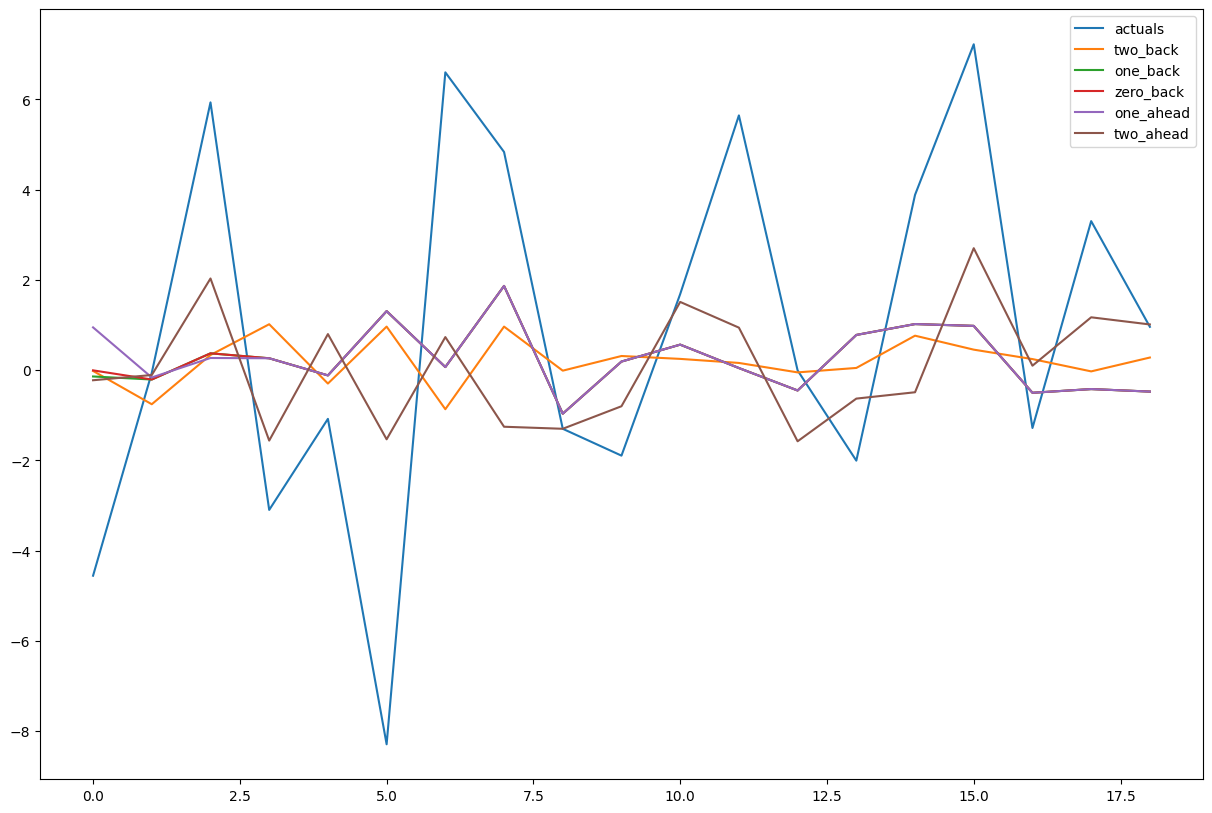

In [27]:
evaluate_lasso(data = data, target_variable='construction', model_params=construction_opt, plot=1, save=1)